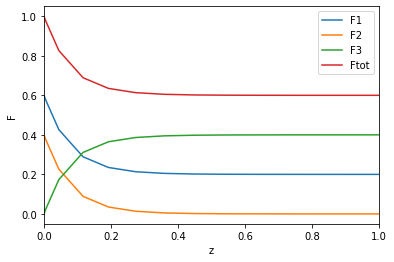

In [6]:
# import required packages
import math
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

# define the reaction rate parameters and pressure (in kPa) and initial 
# temperature (in K)
k = [1.0e-3, 200.]
P0 = 150.
T0 = 350.
dpdz = 10.

# physical properties: density rho in kg/m3 and themal capacity Cp in J/(mol K)
rho = 10.
Cp = 1.5

# function for the Arrhenius equation
def arrh(A, Ea, T): 
    return A * math.exp(-Ea/(const.R * T))

# define the reaction rate model. It returns a list of reaction rates depending 
# on partial pressures of the components.
def reaction_rates_gas(x, k, T, P): 
    r = arrh(k[0], k[1], T) * x[0] * x[1] * P * P
    return [-r, -r, r]

# function to calculate enthalpy change due to reaction
def calc_DeltaH(r):
    H_A = 0.
    H_B = -100.
    H_C = -300.
    return -r[0] * H_A - r[1] * H_B + r[2] * H_C

# define the plug flow reactor model
def plug_flow_reactor_gas(z, Y, dpdz, model_param, reaction_model): 
    F = Y[0:-2]
    H = Y[-2] / F.sum()
    P = Y[-1]
    Ftot = F.sum()
    x = [f / Ftot for f in F]
    T = H / Cp
    r = reaction_model(x, model_param, T, P)
    dH = calc_DeltaH(r)
    dP = -dpdz
    dY = r
    dY.append(dH)
    dY.append(dP)
    return dY

# define initial values for C and the span for calculation (0 to 1)
F0 = [0.6, 0.4, 0.0]
Y0 = F0
H0 = sum(F0) * Cp * T0
Y0.append(H0)
Y0.append(P0)
span = [0.0, 1.0]
# solve the problem and plot the solution
# note how we can pass parameters to the function using the args 
# keyword argument of solve_ivp
sol = solve_ivp(plug_flow_reactor_gas, span, F0, args = (dpdz, k, reaction_rates_gas))
Ftot = np.sum(sol.y[0:3, :], axis = 0)
# for quick plotting we can use matplotlib.pyplot that provides a Matlab-like
# plotting interface
plt.plot(sol.t, sol.y[0,:])
plt.plot(sol.t, sol.y[1,:])
plt.plot(sol.t, sol.y[2,:])

plt.plot(sol.t, Ftot)
plt.xlabel("z")
plt.ylabel("F")
plt.legend(["F1", "F2", "F3", "Ftot"])
plt.xlim((0., 1.0))
plt.show()

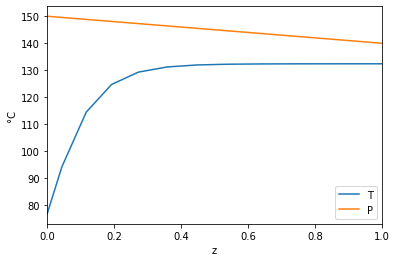

In [10]:
E = sol.y[3,:]
P = sol.y[4,:]
H = E / Ftot
T = H / Cp - 273.15
plt.plot(sol.t, T)
plt.plot(sol.t, P)
plt.xlabel("z")
plt.ylabel("°C")
plt.legend(["T", "P"])
plt.xlim((0., 1.0))
plt.show()